In [43]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
import math
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


33333333333333333333333333333333333333333333333333

Epoch 1 [Training]: 100%|██████████| 2650/2650 [17:23<00:00,  2.54it/s]


Epoch 1 Train Loss: 4.1764 | Val Loss: 3.1340


Epoch 2 [Training]: 100%|██████████| 2650/2650 [17:17<00:00,  2.55it/s]


Epoch 2 Train Loss: 3.3422 | Val Loss: 2.8298


Epoch 3 [Training]: 100%|██████████| 2650/2650 [17:15<00:00,  2.56it/s]


Epoch 3 Train Loss: 3.1140 | Val Loss: 2.6473


Epoch 4 [Training]: 100%|██████████| 2650/2650 [17:19<00:00,  2.55it/s]


Epoch 4 Train Loss: 2.9709 | Val Loss: 2.5427


Epoch 5 [Training]: 100%|██████████| 2650/2650 [16:56<00:00,  2.61it/s]


Epoch 5 Train Loss: 2.8682 | Val Loss: 2.4575


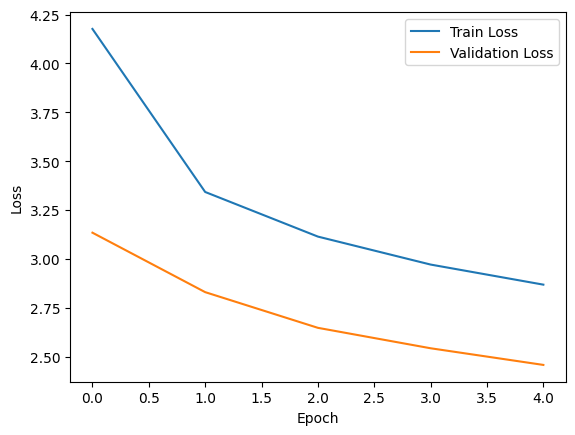

In [46]:
# Cell 1: Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset

# Cell 2: Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

# Cell 3: MultiHeadAttention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.scale = math.sqrt(self.d_k)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn, V)
        return output, attn

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        context, attn = self.scaled_dot_product_attention(Q, K, V, mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.W_o(context), attn

# Cell 4: FeedForward
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

# Cell 5: Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output, attn_weights = self.attn(x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x, attn_weights

# Cell 6: GPT2 Model
class GPT2(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2, d_ff=512, max_len=512, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len = x.size()
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        attn_weights = []

        causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=x.device)).bool()
        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)
            combined_mask = mask & causal_mask
        else:
            combined_mask = causal_mask.unsqueeze(0).unsqueeze(0)

        for block in self.transformer_blocks:
            x, attn = block(x, combined_mask)
            attn_weights.append(attn)

        logits = self.output_layer(x)
        return logits, attn_weights

# Cell 7: Prepare Dataset and DataLoaders
dataset = load_dataset("roneneldan/TinyStories", split="train[:1%]")
val_dataset = load_dataset("roneneldan/TinyStories", split="validation[:1%]")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

class TinyStoriesDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return self.encodings["input_ids"][idx], self.encodings["attention_mask"][idx]

train_dataset = TinyStoriesDataset(tokenized_dataset)
val_dataset = TinyStoriesDataset(tokenized_val_dataset)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Cell 8: Training with checkpoint saving and resuming
def train_model(model, train_loader, val_loader, tokenizer, num_epochs=5, device='cuda', checkpoint_path='checkpoint.pth'):
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    start_epoch = 0
    train_losses, val_losses = [], []

    # Resume if checkpoint exists
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint.get('train_losses', [])
        val_losses = checkpoint.get('val_losses', [])

    model.to(device)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_train_loss = 0
        for xb, mask in tqdm(train_loader, desc=f"Epoch {epoch+1} [Training]"):
            xb, mask = xb.to(device), mask.to(device)
            logits, _ = model(xb, mask)
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = xb[..., 1:].contiguous()

            loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)),
                           shift_labels.view(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, mask in val_loader:
                xb, mask = xb.to(device), mask.to(device)
                logits, _ = model(xb, mask)
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = xb[..., 1:].contiguous()

                loss = loss_fn(shift_logits.view(-1, shift_logits.size(-1)),
                               shift_labels.view(-1))
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses
        }, checkpoint_path)

    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Cell 9: Run training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = tokenizer.vocab_size
model = GPT2(vocab_size=vocab_size)

train_model(model, train_loader, val_loader, tokenizer, num_epochs=5, device=device)


In [85]:
import torch
import torch.nn.functional as F # Import for softmax

def generate_story(model, tokenizer, prompt="once upon a time", max_length=100, temperature=1.0, device='cpu'):
    model.eval()
    tokens = tokenizer.encode(prompt, return_tensors="pt").to(device)  # shape: [1, seq_len]
    generated = tokens

    with torch.no_grad():
        for _ in range(max_length):
            logits, _ = model(generated)
            next_token_logits = logits[:, -1, :]  # last token logits

            # Apply temperature
            # A higher temperature (e.g., > 1.0) makes the distribution flatter,
            # encouraging more diverse and "creative" outputs.
            # A lower temperature (e.g., < 1.0) makes the distribution sharper,
            # leading to more conservative and predictable outputs.
            # temperature = 1.0 is equivalent to no temperature scaling for sampling.
            if temperature == 0.0: # Handle temperature 0 explicitly for greedy decoding
                next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
            else:
                probabilities = F.softmax(next_token_logits / temperature, dim=-1)
                next_token_id = torch.multinomial(probabilities, num_samples=1) # Sample based on probabilities

            generated = torch.cat((generated, next_token_id), dim=1)

            # Check for EOS token
            if next_token_id.item() == tokenizer.eos_token_id:
                break

    story = tokenizer.decode(generated[0], skip_special_tokens=True)
    return story

# --- Usage after training: ---
model.to(device)
prompt = "once upon a time"

print("--- Story ---")
print(generate_story(model, tokenizer, prompt, max_length=100, temperature=0.7, device=device))



--- Story ---
once upon a time, was a little girl named Lily. She loved to play outside in the sky. One day, she found a rock on the ground. It was very weird and wanted to see what it was over. She wanted to do with it, but she started to pull it.

Lily was sad as she was inside and had taken it. She asked her mom what she was wrong and told her that she could do. She was a funny trophy she could not find it.

From
